# 1D CNN model with MFCC mean and data augmentation

### Import libraries

In [2]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

### Augmentation methods

In [2]:
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data preparation and processing

In [61]:
# lets pick up the meta-data that we got from our first part of the Kernel

ref = pd.read_csv("C:/Users/aksha/Downloads/College Project/Code/SpeechEmotionRecognitionwithCNN/Data_path.csv")

ref.head()

,labels,source,path
0,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
1,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
2,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
3,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...
4,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...


C:\Users\aksha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


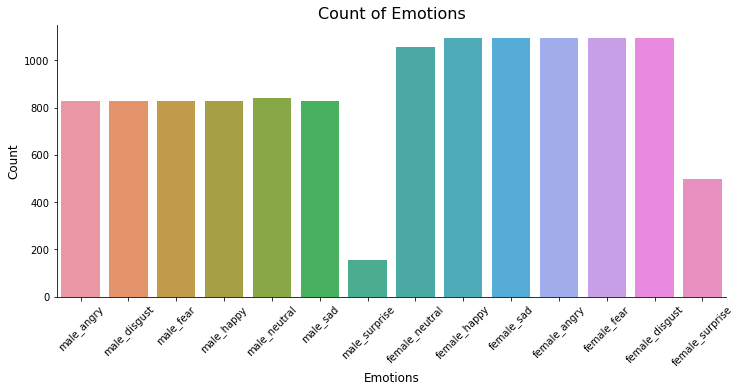

In [62]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(ref.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [4]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

100%|████████████████████████████████████████████████████████████████████████████| 12162/12162 [11:38<00:00, 17.40it/s]


,feature
0,"[-11.113932, -7.2157545, -6.2191906, -5.926542..."
1,"[-24.44983, -22.465742, -22.928043, -23.243807..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458632, -22.467833, -25.884357, -27.82704..."


In [5]:
# save it
df.to_pickle('my4EmotionDatabases-with-augmentation')
# load it
df = pd.read_pickle('my4EmotionDatabases-with-augmentation')
df.head()

,feature
0,"[-11.113932, -7.2157545, -6.2191906, -5.926542..."
1,"[-24.44983, -22.465742, -22.928043, -23.243807..."
2,"[-25.000114, -24.520256, -24.178183, -23.84745..."
3,"[-1.529839, -4.333437, -12.285238, -13.083024,..."
4,"[-22.458632, -22.467833, -25.884357, -27.82704..."


In [6]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(12162, 219) (12162, 219) (12162, 219)


In [7]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-11.113932,-7.215755,-6.219191,-5.926542,-5.850419,-4.808960,-2.513003,...,-4.088851,-5.023864,-5.254714,-5.234093,-5.310308,-5.621667,-6.072197,-6.611348,-2.509089,1.964608
1,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-24.449829,-22.465742,-22.928043,-23.243807,-22.926605,-23.432241,-14.830002,...,-22.627258,-22.633406,-22.511599,-24.300154,-24.496809,-22.895985,-23.511503,-24.342152,-24.530262,-25.457796
2,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-25.000114,-24.520256,-24.178183,-23.847450,-15.182783,-10.732485,-8.681472,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-1.529839,-4.333437,-12.285238,-13.083024,-12.041327,-11.819768,-9.414148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male_angry,SAVEE,C:/Users/aksha/Downloads/College Project/Data ...,-22.458632,-22.467833,-25.884357,-27.827045,-27.593534,-26.666508,-18.659023,...,-25.291666,-25.854906,-26.821354,-25.436455,-24.179941,-23.281618,-24.167494,-25.228062,-25.902941,-25.589964


### Splitting the Dataset into Training and Test

In [8]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,-13.177674,-14.403879,-17.543428,-19.350146,-19.386313,-19.184240,-20.747841,-21.342071,-22.389735,-20.873558,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7298,-8.027396,-10.838160,-12.255647,-11.898201,-10.756337,-9.941221,-9.175518,-10.040980,-11.818560,-12.569689,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5874,-17.870501,-17.714832,-17.618549,-16.609169,-16.510859,-16.902693,-16.642063,-15.599797,-17.691359,-17.750959,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
858,-24.170978,-22.970630,-23.251750,-23.086537,-23.829079,-21.728722,-20.741388,-24.019000,-24.972264,-24.091771,...,-18.456240,-18.083539,-18.068480,-17.183503,-18.140720,-18.995897,-18.337440,-17.962929,-15.674130,-11.480967
891,-36.732196,-35.572770,-35.166631,-33.871459,-34.924611,-35.097458,-37.965253,-40.583790,-39.640019,-39.769818,...,-21.977303,-21.558330,-23.068096,-22.980879,-22.734655,-21.776787,-21.548141,-23.486307,-21.579386,-19.557061
1748,-52.554022,-51.667698,-50.563459,-48.702666,-45.879755,-44.516427,-46.154868,-48.769899,-48.140774,-47.180000,...,-44.545493,-44.547248,-44.395103,-44.569200,-45.696519,-45.216083,-47.059853,-49.719179,-51.057464,-50.536842
9995,-3.856008,-6.235306,-7.685878,-7.710427,-9.083555,-8.221647,-8.415779,-9.534316,-7.854500,-7.269660,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5771,-16.097866,-14.964050,-17.066648,-17.905895,-17.704601,-16.798386,-17.002083,-14.373887,-13.946707,-11.543315,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1029,-51.060482,-49.656395,-48.319878,-48.349445,-47.518894,-48.807171,-53.199306,-50.905838,-48.907475,-49.427498,...,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570,-57.017570
10882,-12.439851,-14.354954,-13.388746,-11.208921,-10.766116,-10.611308,-9.703167,-9.880795,-11.924343,-14.752300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Data Normalization

In [9]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,0.529232,0.491466,0.435397,0.282900,0.273626,0.284549,0.153754,0.102190,0.014070,0.131184,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378
7298,0.925049,0.777604,0.862534,0.883412,0.967779,1.027178,1.081653,1.007201,0.860224,0.795765,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378
5874,0.168571,0.225772,0.429328,0.503780,0.504913,0.467859,0.482966,0.562041,0.390145,0.381094,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378
858,-0.315643,-0.195990,-0.025711,-0.018196,-0.083729,0.080113,0.154271,-0.112183,-0.192644,-0.126378,...,-0.432205,-0.431970,-0.430477,-0.381915,-0.454681,-0.498700,-0.461601,-0.460320,-0.341379,-0.116887
891,-1.281018,-1.207274,-0.988172,-0.887294,-0.976199,-0.993995,-1.226784,-1.438720,-1.366703,-1.381133,...,-0.616561,-0.615246,-0.693965,-0.687018,-0.698646,-0.646220,-0.631638,-0.755067,-0.656801,-0.546872
1748,-2.496982,-2.498844,-2.231899,-2.082461,-1.857377,-1.750761,-1.883449,-2.094278,-2.047133,-1.974190,...,-1.798191,-1.827789,-1.817934,-1.823161,-1.918059,-1.889629,-1.982726,-2.154946,-2.231339,-2.196286
9995,1.245635,1.146969,1.231671,1.220882,1.102329,1.165336,1.142571,1.047776,1.177522,1.219940,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378
5771,0.304804,0.446514,0.473910,0.399284,0.408894,0.476240,0.454099,0.660214,0.689880,0.877908,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378
1029,-2.382198,-2.337443,-2.050666,-2.053997,-1.989222,-2.095500,-2.448291,-2.265328,-2.108502,-2.154063,...,-2.451206,-2.485533,-2.483160,-2.478290,-2.519274,-2.515674,-2.510082,-2.544414,-2.549692,-2.541331
10882,0.585936,0.495392,0.771004,0.938957,0.966992,0.973340,1.039345,1.020029,0.851757,0.621084,...,0.534131,0.521841,0.521762,0.522413,0.508700,0.508995,0.509541,0.498246,0.495837,0.494378


In [10]:
# Make the dataset keras compatible
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(27364, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [11]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(27364, 216, 1)

# Modelling

In [12]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

C:\Users\aksha\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

Epoch 1/150
1711/1711 - 195s - loss: 2.3446 - accuracy: 0.2004 - val_loss: 2.2805 - val_accuracy: 0.2361
Epoch 2/150
1711/1711 - 193s - loss: 2.1366 - accuracy: 0.2605 - val_loss: 2.1697 - val_accuracy: 0.2793
Epoch 3/150
1711/1711 - 195s - loss: 2.0358 - accuracy: 0.2940 - val_loss: 2.1061 - val_accuracy: 0.3002
Epoch 4/150
1711/1711 - 196s - loss: 1.9659 - accuracy: 0.3144 - val_loss: 2.0333 - val_accuracy: 0.3152
Epoch 5/150
1711/1711 - 195s - loss: 1.9112 - accuracy: 0.3332 - val_loss: 1.9988 - val_accuracy: 0.3248
Epoch 6/150
1711/1711 - 193s - loss: 1.8657 - accuracy: 0.3501 - val_loss: 1.9564 - val_accuracy: 0.3393
Epoch 7/150
1711/1711 - 195s - loss: 1.8265 - accuracy: 0.3608 - val_loss: 1.9265 - val_accuracy: 0.3547
Epoch 8/150
1711/1711 - 193s - loss: 1.7948 - accuracy: 0.3719 - val_loss: 1.9036 - val_accuracy: 0.3520
Epoch 9/150
1711/1711 - 193s - loss: 1.7683 - accuracy: 0.3832 - val_loss: 1.8876 - val_accuracy: 0.3565
Epoch 10/150
1711/1711 - 193s - loss: 1.7389 - accuracy

Epoch 79/150
1711/1711 - 196s - loss: 1.0854 - accuracy: 0.6291 - val_loss: 1.5920 - val_accuracy: 0.4551
Epoch 80/150
1711/1711 - 197s - loss: 1.0741 - accuracy: 0.6298 - val_loss: 1.5837 - val_accuracy: 0.4556
Epoch 81/150
1711/1711 - 198s - loss: 1.0660 - accuracy: 0.6344 - val_loss: 1.5818 - val_accuracy: 0.4466
Epoch 82/150
1711/1711 - 196s - loss: 1.0560 - accuracy: 0.6414 - val_loss: 1.5801 - val_accuracy: 0.4563
Epoch 83/150
1711/1711 - 196s - loss: 1.0559 - accuracy: 0.6392 - val_loss: 1.5453 - val_accuracy: 0.4657
Epoch 84/150
1711/1711 - 196s - loss: 1.0457 - accuracy: 0.6439 - val_loss: 1.5545 - val_accuracy: 0.4590
Epoch 85/150
1711/1711 - 196s - loss: 1.0392 - accuracy: 0.6429 - val_loss: 1.6105 - val_accuracy: 0.4498
Epoch 86/150
1711/1711 - 197s - loss: 1.0292 - accuracy: 0.6487 - val_loss: 1.5608 - val_accuracy: 0.4602
Epoch 87/150
1711/1711 - 202s - loss: 1.0216 - accuracy: 0.6519 - val_loss: 1.5390 - val_accuracy: 0.4713
Epoch 88/150
1711/1711 - 196s - loss: 1.0126 -

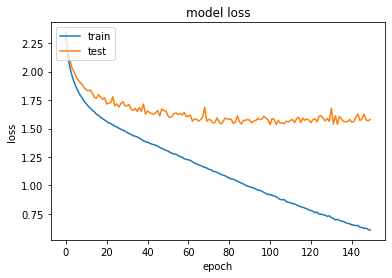

In [14]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
0
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model serialisation

In [15]:
# Save model and weights
model_name = 'Emotion_Model_1D_CNN_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_1D_CNN_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at C:\Users\aksha\Downloads\College Project\Code\SER\saved_models\Emotion_Model_1D_CNN_aug.h5 


# Model validation

In [16]:
# loading json and model architecture 
json_file = open('model_json_1D_CNN_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_1D_CNN_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 48.22%


In [17]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

571/571 [==============================] - 12s 20ms/step


array([2, 1, 1, ..., 9, 0, 9], dtype=int64)

In [18]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_surprise,female_surprise
171,female_fear,female_fear
172,female_neutral,female_neutral
173,female_neutral,female_sad
174,male_surprise,male_happy
175,male_disgust,male_neutral
176,female_fear,female_fear
177,female_disgust,female_disgust
178,male_neutral,male_sad
179,male_fear,female_neutral


In [19]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,1029
female_disgust,892
female_fear,1081
female_happy,1211
female_neutral,741
female_sad,830
female_surprise,306
male_angry,408
male_disgust,385


### Emotion by gender accuracy for 1D CNN model with MFCC mean and Data augmentation

0.4822407366805525


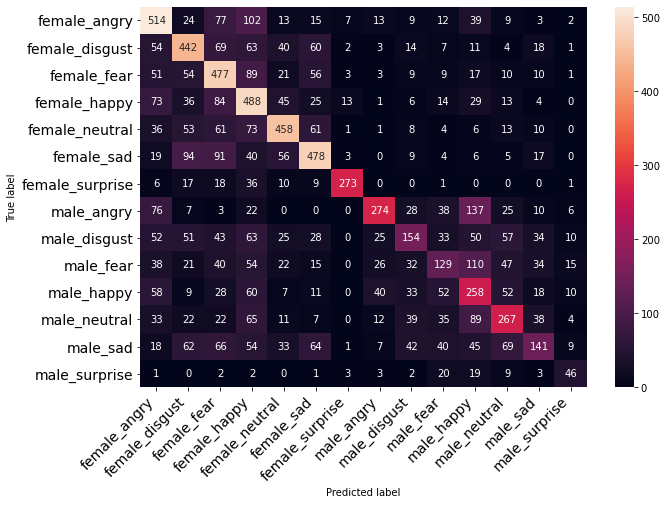

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.50      0.61      0.55       839
 female_disgust       0.50      0.56      0.53       788
    female_fear       0.44      0.59      0.50       810
   female_happy       0.40      0.59      0.48       831
 female_neutral       0.62      0.58      0.60       785
     female_sad       0.58      0.58      0.58       822
female_surprise       0.89      0.74      0.81       371
     male_angry       0.67      0.44      0.53       626
   male_disgust       0.40      0.25      0.30       625
      male_fear       0.32      0.22      0.26       583
     male_happy       0.32      0.41      0.36       636
   male_neutral       0.46      0.41      0.44       644
       male_sad       0.41      0.22      0.28       651
  male_surprise       0.44      0.41      0.43       111

       accuracy                           0.48      9122
      macro avg       0.50      0.47      0.47      9122
   weighted avg       0.49   

### Gender accuracy result for 1D CNN model with MFCC mean and Data augmentation

0.829423372067529


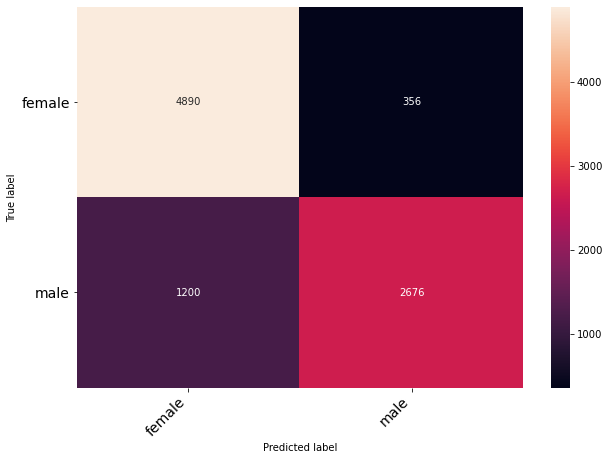

In [22]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.80      0.93      0.86      5246
        male       0.88      0.69      0.77      3876

    accuracy                           0.83      9122
   macro avg       0.84      0.81      0.82      9122
weighted avg       0.84      0.83      0.83      9122



### Emotion accuracy for 1D CNN model with MFCC mean and Data augmentation

0.526200394650296


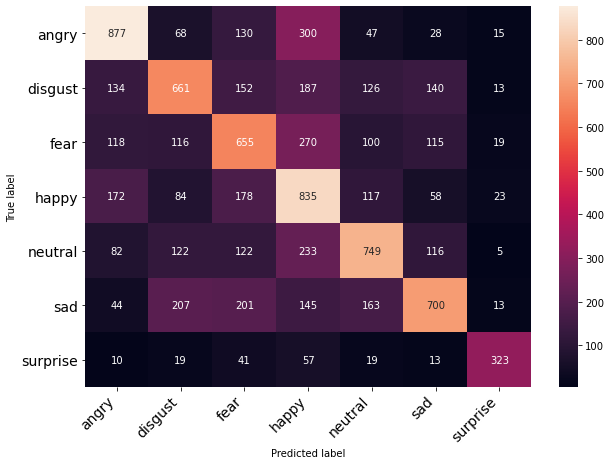

In [24]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60      1465
     disgust       0.52      0.47      0.49      1413
        fear       0.44      0.47      0.46      1393
       happy       0.41      0.57      0.48      1467
     neutral       0.57      0.52      0.54      1429
         sad       0.60      0.48      0.53      1473
    surprise       0.79      0.67      0.72       482

    accuracy                           0.53      9122
   macro avg       0.56      0.54      0.55      9122
weighted avg       0.54      0.53      0.53      9122



### Live Demo for 2D CNN with MFCC without augmentation

### Test 1

In [3]:
path = "C:/Users/aksha/Downloads/College Project/Data Set/Test Data/DC_a06.wav"
data2, sampling_rate2 = librosa.load(path)
#path = "C:/Users/aksha/Downloads/College Project/Code/SER/output10.wav"
#data2, sampling_rate2 = librosa.load(path)
ipd.Audio(path)

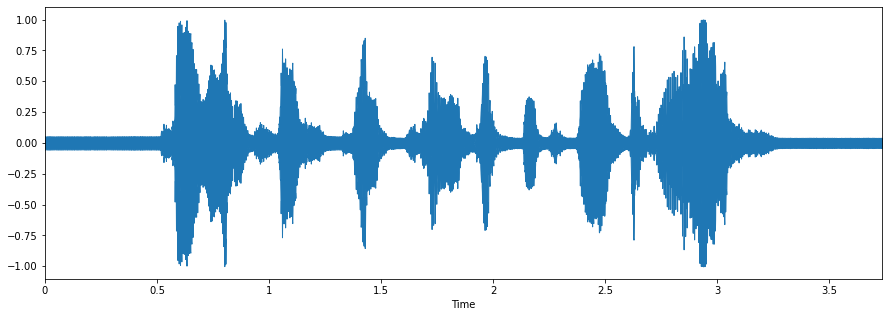

In [55]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data2, sr=sampling_rate2)

In [56]:
# loading json and model architecture 
json_file = open('model_json_1D_CNN_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_1D_CNN_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


C:\Users\aksha\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [57]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load(path
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=30),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-5.575934,-5.347874,-5.990893,-6.5927,-6.548381,-4.856196,-4.442081,-4.017504,-4.337191,-4.936345,...,-3.953266,-4.043708,-4.398498,-3.784654,-3.441833,-4.21003,-4.438338,-5.230594,-2.911551,-1.080014


In [58]:
# Apply predictions
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 0s 119ms/step


array([[1.76356749e-10, 2.05195785e-01, 2.65483641e-06, 1.85236104e-09,
        1.12146927e-05, 1.08610075e-02, 2.11733891e-06, 6.36092238e-07,
        1.19619347e-01, 9.51801310e-04, 3.32824893e-05, 4.12792360e-05,
        6.63270116e-01, 1.07381011e-05]], dtype=float32)

In [60]:
import pickle
filename = 'C:/Users/aksha/Downloads/College Project/Code/SER/labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['male_sad']


### Test 2

In [4]:
#path = "C:/Users/aksha/Downloads/College Project/Data Set/Test Data/DC_a06.wav"
path = "C:/Users/aksha/Downloads/College Project/Code/SER/output10.wav"
data, sampling_rate = librosa.load(path)
ipd.Audio(path)

In [42]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

UsageError: Line magic function `%` not found.


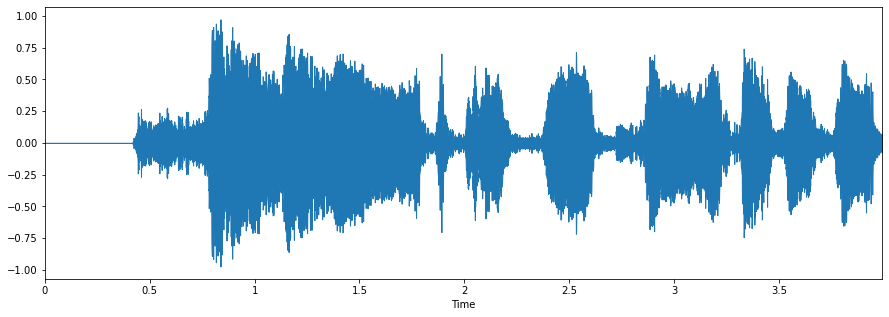

In [43]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [44]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=30),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [45]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-2.811769,-1.758735,-0.729367,0.411406,1.035888,0.711248,0.022991,-0.71801,-1.592555,-1.12826,...,0.207582,0.309026,-0.291599,-1.475189,-2.479775,-2.68735,-3.198664,-3.538884,-3.100578,0.230897


In [46]:
twodim= np.expand_dims(livedf2, axis=2)

In [47]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 14ms/step


In [48]:
livepreds

array([[1.1289587e-06, 6.6756867e-05, 1.4687458e-02, 6.4925892e-08,
        7.4310592e-06, 9.4389868e-01, 4.1390789e-09, 6.3886960e-06,
        9.5956326e-03, 2.9479017e-04, 1.2564706e-04, 7.0346263e-04,
        3.0612575e-02, 1.1608632e-10]], dtype=float32)

In [49]:
livepreds.shape

(1, 14)

In [51]:
livepreds1=livepreds.argmax(axis=1)

In [52]:
liveabc = livepreds1.astype(int).flatten()

In [53]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_sad'], dtype=object)